In [1]:
from imutils.video import WebcamVideoStream
from imutils.video import FPS
import argparse
import imutils
import cv2
from datetime import datetime
import dlib
import serial
import time
import numpy as np

#inside retinaFace implementation, changed gpu from cuda to mps
from face_detection import RetinaFace
import torch
import torch.nn.functional as F
import sys
sys.path.append('sphereface_pytorch')
from net_sphere import sphere20a
from matlab_cp2tform import get_similarity_transform_for_cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

Abbiamo rilevato che il metodo migliore non è quello di avere un database di utenti ma quello di aggiungerli "al volo" selezionandone uno tra le facce presenti a video. Questo lo rende anche più robusto per quanto riguarda i diversi ambienti in cui potrebbero essere creati gli embedding (se li creo in camera mia, e lo testo in uni la similarità sarà più bassa che se li testo in camera mia).

Abbiamo notato che, in casi normali, è più robusto affidarsi al tracking e non allo score di similarità (che varia molto quando il viso non è vicino e ben allineato). Decidiamo quindi (prossimo step da implementare) di utilizzare lo score di similarità solo nei casi limite (eg sto seguendo anto, lui esce e rientra dall'inquadratura, in quel caso mi calcolo gli embedding e seguo il più simile, magari con un threshold). 

In [2]:
#Loading sphereface model
device = torch.device("mps")
emb_model = sphere20a(feature=True)
emb_model.load_state_dict(torch.load("model/sphere20a_20171020.pth"))
emb_model = emb_model.to(device)

In [3]:
detector = RetinaFace(0)

In [4]:
def alignment(src_img, src_pts):
    ref_pts = [
        [30.2946, 51.6963],
        [65.5318, 51.5014],
        [48.0252, 71.7366],
        [33.5493, 92.3655],
        [62.7299, 92.2041],
    ]
    crop_size = (96, 112)
    src_pts = np.array(src_pts).reshape(5, 2)

    s = np.array(src_pts).astype(np.float32)
    r = np.array(ref_pts).astype(np.float32)

    tfm = get_similarity_transform_for_cv2(s, r)
    face_img = cv2.warpAffine(src_img, tfm, crop_size)
    return face_img

In [5]:
from torchvision.transforms import Resize, Lambda, Compose

emb_transform  = Compose([
    Lambda(lambda x: torch.from_numpy(x).float()),
    Lambda(lambda x: (x - 127.5 ) / 128.0),
    Lambda(lambda x: x.permute(0, 3, 1, 2))
])

In [6]:
IMG_SIZE = (720, 400)


# Specify the serial port your Arduino is connected to
arduino_port = (
    "/dev/cu.usbmodem21201"  # Change this to your port (e.g., 'COM3' on Windows)
)

# Establish serial communication
#ser = serial.Serial(arduino_port, 2000000, timeout=1)

https://github.com/elliottzheng/face-detection

In [7]:
def apply_bbox_to_frame(frame, bbox, color=(0, 255, 0)):
    cv2.rectangle(
        frame,
        (int(bbox[0]), int(bbox[1])),
        (int(bbox[2]), int(bbox[3])),
        color,
        2,
    )


def display_similarity(frame, similarity, bbox):
    xmin, ymin, _, _ = np.int32(bbox)
    cv2.putText(
        frame,
        f"Sim: {similarity:.2f}",
        (xmin, ymin - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 0),
        1,
    )

In [8]:
class Person:
    def __init__(self, bbox, keypoints, embedding=None):
        self.bbox = bbox
        self.keypoints = keypoints
        self.embedding = embedding
        self.color = (0, 0, 255)  # red

    def update(self, bbox, keypoints, embedding=None):
        self.bbox = bbox
        self.keypoints = keypoints
        self.embedding = embedding

    def __lt__(self, other):
        return (self.bbox[0] + self.bbox[2]) < (other.bbox[0] + other.bbox[2])

In [9]:
def match(persons, pred):
    taken = []
    if persons is None:
        return []

    for i, p in enumerate(pred):
        min_dist = np.inf
        idx = None
        for j, person in enumerate(persons):
            if len(taken) > 0 and j in taken:
                continue
            dist = np.linalg.norm(person.bbox - p[0])
            if dist < min_dist:
                min_dist = dist
                idx = j

        if idx is not None:
            taken.append(idx)
            persons[idx].update(p[0], p[1])
        else:
            persons.append(Person(p[0], p[1]))
            taken.append(len(persons) - 1)

    to_remove = [i for i in range(len(persons)) if i not in taken]
    for i in range(len(persons)):
        if i in to_remove:
            persons.remove(persons[i])

In [15]:
def send_coordinates(x, y):
    x = round(x, 3)
    y = round(y, 3)
    data = f"{x},{y}\n"
    ser.write(data.encode("utf-8"))
    print(data)


target = None
num_frames = 0
send_every = 3  # send coordinates every n frames

# created a *threaded* video stream, allow the camera sensor to warmup,
# and start the FPS counter
print("[INFO] sampling THREADED frames from webcam...")
vs = WebcamVideoStream(src=0).start()
# loop over some frames...this time using the threaded stream
start = datetime.now()
fps = 0

last_pred = None
persons = []
tracked_person = None
with torch.no_grad():
    while True:
        # grab the frame from the threaded video stream and resize it
        # to have a maximum width of 400 pixels
        frame = vs.read()
        frame = cv2.resize(frame, dsize=IMG_SIZE)
        # check to see if the frame should be displayed to our screen
        frame = cv2.flip(frame, 1)
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # detect face
        pred = detector(img_rgb)
        if len(pred) == 0:
            continue

        # Replace list comprehensions with numpy operations
        pred = [p for p in pred if p[2] > 0.7]
        match(persons, pred)
        persons.sort()
        if tracked_person not in persons:
            tracked_person = None

        if len(persons) > 0:
            if tracked_person is None:
                tracked_person = persons[0]
                tracked_person.color = (0, 255, 0)  # green

            if target is not None:
                aligned = np.array([alignment(img_rgb, p.keypoints) for p in persons])
                embs = emb_model(emb_transform(aligned).to(device)).detach().cpu().numpy()
                sims = F.cosine_similarity(torch.tensor(embs), torch.tensor(target), dim=-1)

                # Combine the last two list comprehensions
                [
                    apply_bbox_to_frame(frame, p.bbox, p.color)
                    or display_similarity(frame, s, p.bbox)
                    for i, (s, p) in enumerate(zip(sims, persons))
                ]
            else:
                [apply_bbox_to_frame(frame, p.bbox, p.color) for p in persons]
        else:
            tracked_person = None

        if num_frames > 0:
            fps_str = f"FPS: {fps}"
            # print(type(fps_str))
            cv2.putText(
                frame,
                fps_str,
                org=(10, 30),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(0, 255, 0),
                thickness=1,
            )

        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

        if tracked_person is not None:
            if key == ord("s"):
                target = alignment(img_rgb, tracked_person.keypoints)
                target = (
                    emb_model(emb_transform(np.array([target])).to(device))
                    .detach()
                    .cpu()
                    .numpy()
                )

            tracked_person.color = (0, 0, 255)
            if key == ord("a"):
                idx = persons.index(tracked_person)
                tracked_person = persons[idx - 1 if idx > 0 else idx]
            if key == ord("d"):
                idx = persons.index(tracked_person)
                tracked_person = persons[idx + 1 if idx < len(persons) - 1 else idx]

            tracked_person.color = (0, 255, 0)

        # update the FPS counter
        num_frames += 1
        if (datetime.now() - start).total_seconds() > 1:
            start = datetime.now()
            fps = num_frames 
            num_frames = 0


    cv2.destroyAllWindows()
    vs.stop()
    # ser.close()

[INFO] sampling THREADED frames from webcam...


In [14]:
def moving_average_filter(data, window_size=3):
    """
    Apply a simple moving average filter to the input data. 

    Parameters:
    - data: Input data (list or numpy array).
    - window_size: Size of the moving average window.

    Returns:
    - smoothed_data: Data after applying the moving average filter.
    """
    weights = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, weights, mode='valid')
    return smoothed_data

def send_coordinates(x, y):
    # Send x and y coordinates to the robotic arm
    data = f"{x} {y}\n"
    ser.write(data.encode())

# Example usage:
x_coordinates = [377, 373, 360, 350]
y_coordinates = [541, 524, 523]

# Apply a moving average filter to the coordinates
window_size = 3
smoothed_x = moving_average_filter(x_coordinates, window_size)
smoothed_y = moving_average_filter(y_coordinates, window_size)

smoothed_x

array([370., 361.])

In [ ]:
import matplotlib.pyplot as plt
vs = WebcamVideoStream(src=0).start()

frame = vs.read()
frame = imutils.resize(frame)
# check to see if the frame should be displayed to our screen
frame = cv2.flip(frame, 1)
img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
img_rgb = np.array(img_rgb)

In [2]:
plt.imshow(img_rgb)

NameError: name 'plt' is not defined

In [3]:
KEYPOINT_COLOR = (0, 255, 0) # Green

def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=2):
    image = image.copy()

    for (x, y) in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, color, -1)
        
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image)

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

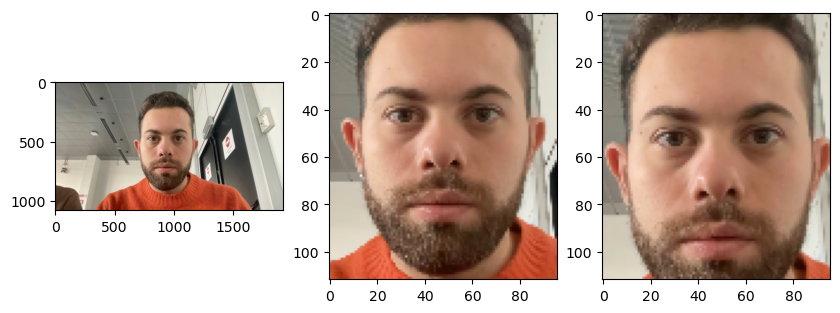

In [34]:
pred = detector(img_rgb)[0]
bbox = np.array(pred[0], dtype=np.int32)
keypoints = np.array(pred[1])
aligned2 = alignment(img_rgb, keypoints)
aligned = align_image(img_rgb, bbox, keypoints, pad = 80)
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_rgb)
ax[1].imshow(aligned)
ax[2].imshow(aligned2)

In [16]:
#!git clone https://github.com/clcarwin/sphereface_pytorch.git

In [35]:
import sys
sys.path.append('sphereface_pytorch')

In [36]:
from net_sphere import sphere20a

device = torch.device("mps")
emb_model = sphere20a(feature=True)
emb_model.load_state_dict(torch.load("model/sphere20a_20171020.pth"))
emb_model = emb_model.to(device)

In [37]:
aligned = alignment(img_rgb, keypoints)
#aligned = emb_transform(image=aligned)["image"].unsqueeze(0).to(device)
aligned = emb_transform(aligned).unsqueeze(0).to(device)
aligned.shape

torch.Size([1, 3, 112, 96])

In [38]:
nic_emb = emb_model(aligned)[0]
#save nic_emb to a txt file
np.savetxt("nic_emb.txt", nic_emb.cpu().detach().numpy())